# Exercises

1. Can you think of a few applications for a sequence-to-sequence RNN? What about a sequence-to-vector RNN, & a vector-to-sequence RNN?
2. How many dimensions must the inputs of an RNN layer have? What does each dimension represent? What about its outputs?
3. If you want to build a deep sequence-to-sequence RNN, which RNN layers should have `return_sequences = True`? What about a sequence-to-vector RNN?
4. Suppose you have a daily univariate time series, & you want to forecast the next seven days. Which RNN architecture should you use?
5. What are the main difficulties when training RNNs? How can you handle them?
6. Can you sketch the LSTM cell's architecture?
7. Why would you want to use 1D convolutional layers in an RNN?
8. Which neural network architecture could you use to classify videos?
9. Train a classification model for the sketchrnn dataset, available in tensorflow datasets.
10. Download the bach chorales dataset & unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, & each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note). Train a model -- recurrent, convolutional, or both -- that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale & asking it to predict the next time step, then appending these time steps to the input sequence & asking the model for the next note, & so on. Also make sure to check out Google's coconet model, which was used for a nice Google doodle about Bach.

---

1. A sequence-to-sequence RNN can be used for predicting time series, such as stock prices. You feed it the prices of the last N days, & it must output the prices shifted by one day into the future (i.e., from N - 1 days ago to tomorrow). A sequence-to-vector RNN takes in a sequence of inputs & ignores all outputs excet for the last one. For example you can feed this network a sequence of words corresponding to a movie revier, & the network would output a sentiment score (e.g., from -1 [hate] to +1 [love]). Conversely, you could feed the network the same input over & over again at each time step & let it output a sequence. This is a vector-to-sequence network, which can be used for image captions.
2. The input features of an RNN layer are generally represented in 3 dimensions, in arrays of shape [*batch size*, *time steps*, *dimensionality*], where *dimensionality* is 1 for univariate time series & more for multivariate time series. The output features are also 3 dimensional with the same first two dimensions, but the last dimension is the number of neurons.
3. For a deep sequence-to-sequence model, you must set `return_sequences = True` in all recurrent layers. For a deep sequence-to-vector model, leave want to set `return_sequences = True` to all recurrent layers but the top recurrent layer.
4. We should use a sequence-to-sequence RNN so that we can train it to forecast the next 7 values at each & every step. We could also use a sequence-to-vector RNN, but it would train the model to forecast the next 7 values only at the very last time step.
5. The two main difficulties that RNNs face are unstable gradients & limited short-term memory. Unstable gradients can be alleviated using various techniques, such as dropout & layer normalisation. The short term memory can be extended using LSTM & GRU cells.
6. <img src = "Images/LSTM Cell.png" width = "500" style = "margin:auto"/>
7. Since a 1D convolutional layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in a RNN by downsampling, thereby helping the RNN layers detect long-term patterns more efficiently. In fact, it is possible to use many convolutional layers, for example, when you build a wavenet architecture.
8. For videos, you have the visual & auditory content. For parallel processing, you could put the visual content into a CNN, where each frame of the video is a different image. You can then take the output of this CNN & run it thorugh a sequence-to-vector RNN that outputs through a softmax layer, giving you the class of your visual content. For the audio content, you would have to downsample by adding a stack of 1D convolutional layers, & then once again, with the output, run it through a sequence-to-vector RNN that outputs through a softmax layer. To combine them both, you would concatenate the outputs of the convolutional layers along the last dimension before running it through the RNN.

# 9.

In [1]:
import tensorflow as tf
from tensorflow import keras

download_root = "http://download.tensorflow.org/data/"
file_name = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(file_name, download_root + file_name,
                                cache_subdir = "data", extract = True)

In [3]:
from pathlib import Path

quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])
train_files

['/Users/jiehengyu/.keras/data/training.tfrecord-00000-of-00010',
 '/Users/jiehengyu/.keras/data/training.tfrecord-00001-of-00010',
 '/Users/jiehengyu/.keras/data/training.tfrecord-00002-of-00010',
 '/Users/jiehengyu/.keras/data/training.tfrecord-00003-of-00010',
 '/Users/jiehengyu/.keras/data/training.tfrecord-00004-of-00010',
 '/Users/jiehengyu/.keras/data/training.tfrecord-00005-of-00010',
 '/Users/jiehengyu/.keras/data/training.tfrecord-00006-of-00010',
 '/Users/jiehengyu/.keras/data/training.tfrecord-00007-of-00010',
 '/Users/jiehengyu/.keras/data/training.tfrecord-00008-of-00010',
 '/Users/jiehengyu/.keras/data/training.tfrecord-00009-of-00010']

In [4]:
eval_files

['/Users/jiehengyu/.keras/data/eval.tfrecord-00000-of-00010',
 '/Users/jiehengyu/.keras/data/eval.tfrecord-00001-of-00010',
 '/Users/jiehengyu/.keras/data/eval.tfrecord-00002-of-00010',
 '/Users/jiehengyu/.keras/data/eval.tfrecord-00003-of-00010',
 '/Users/jiehengyu/.keras/data/eval.tfrecord-00004-of-00010',
 '/Users/jiehengyu/.keras/data/eval.tfrecord-00005-of-00010',
 '/Users/jiehengyu/.keras/data/eval.tfrecord-00006-of-00010',
 '/Users/jiehengyu/.keras/data/eval.tfrecord-00007-of-00010',
 '/Users/jiehengyu/.keras/data/eval.tfrecord-00008-of-00010',
 '/Users/jiehengyu/.keras/data/eval.tfrecord-00009-of-00010']

In [5]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [6]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [7]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype = tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype = tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype = tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape = [tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [8]:
def quickdraw_dataset(filepaths, batch_size = 32, shuffle_buffer_size = None,
                      n_parse_threads = 5, n_read_threads = 5, cache = False):
    dataset = tf.data.TFRecordDataset(filepaths, 
                                      num_parallel_reads = n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls = n_parse_threads)
    return dataset.prefetch(1)

In [9]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size = 10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.046875    0.7647059   0.        ]
  [ 0.0625      0.18823528  0.        ]
  [ 0.046875    0.04313725  1.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.7007874   0.5         0.        ]
  [-0.00393701  0.09500003  0.        ]
  [ 0.02362205  0.04499996  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.43529415  0.09500003  0.        ]
  [-0.20784314  0.065       0.        ]
  [ 0.         -0.65999997  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.11848342 -0.19291341  0.        ]
  [ 0.02843601 -0.13779527  0.        ]
  [ 0.00947869 -0.21259841  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

2024-09-22 18:28:55.265130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
def crop_long_sketches(dataset, max_length = 100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_val_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [11]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size = 5, strides = 2, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size = 5, strides = 2, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size = 3, strides = 2, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences = True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation = "softmax")
])
optimizer = keras.optimizers.SGD(learning_rate = 0.01, clipnorm = 1.0)
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = optimizer,
              metrics = ["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs = 2,
                    validation_data = cropped_val_set)

Epoch 1/2
 107812/Unknown 1982s 18ms/step - accuracy: 0.0817 - loss: 4.8276 - sparse_top_k_categorical_accuracy: 0.2099

2024-09-22 19:01:59.130475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/jiehengyu/opt/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


107813/107813 ━━━━━━━━━━━━━━━━━━━━ 2013s 19ms/step - accuracy: 0.0817 - loss: 4.8276 - sparse_top_k_categorical_accuracy: 0.2099 - val_accuracy: 0.3102 - val_loss: 3.0906 - val_sparse_top_k_categorical_accuracy: 0.5922
Epoch 2/2
     4/107813 ━━━━━━━━━━━━━━━━━━━━ 33:28 19ms/step - accuracy: 0.3021 - loss: 3.2948 - sparse_top_k_categorical_accuracy: 0.5755   

2024-09-22 19:02:29.919296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


107810/107813 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3494 - loss: 2.8666 - sparse_top_k_categorical_accuracy: 0.6371

2024-09-22 19:36:34.403395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


107813/107813 ━━━━━━━━━━━━━━━━━━━━ 2074s 19ms/step - accuracy: 0.3494 - loss: 2.8666 - sparse_top_k_categorical_accuracy: 0.6371 - val_accuracy: 0.4173 - val_loss: 2.4942 - val_sparse_top_k_categorical_accuracy: 0.7061


2024-09-22 19:37:03.866586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def draw_sketch(sketch, label = None):
    origin = np.array([[0.0, 0.0, 0.0]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1] == 1.0)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis = 0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


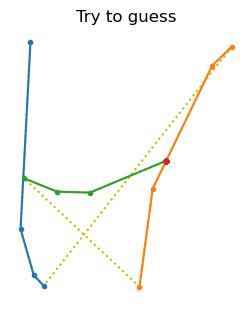

Top-5 predictions:
  1. ladder 39.032%
  2. skyscraper 6.765%
  3. tent 3.842%
  4. fence 3.820%
  5. bed 3.804%
Answer: leg


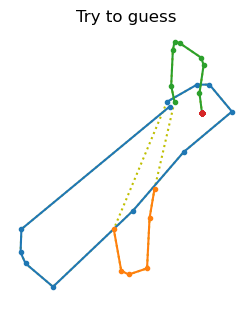

Top-5 predictions:
  1. pencil 14.983%
  2. crayon 8.765%
  3. toothpaste 7.313%
  4. eraser 7.148%
  5. marker 5.451%
Answer: see saw


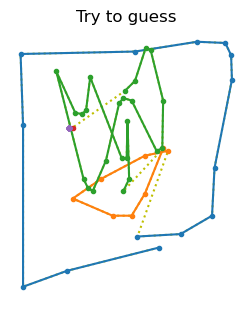

Top-5 predictions:
  1. fireplace 41.948%
  2. camouflage 6.925%
  3. map 4.219%
  4. passport 4.048%
  5. the mona lisa 2.540%
Answer: fireplace


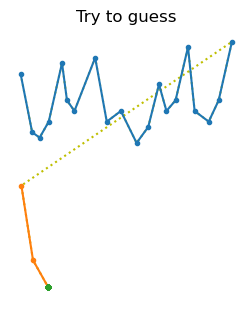

Top-5 predictions:
  1. the great wall of china 34.701%
  2. ocean 25.872%
  3. beach 8.585%
  4. grass 6.445%
  5. river 3.537%
Answer: ocean


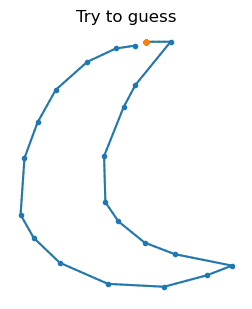

Top-5 predictions:
  1. moon 43.277%
  2. hourglass 13.551%
  3. boomerang 12.745%
  4. peanut 5.369%
  5. telephone 5.054%
Answer: moon


In [17]:
n_new = 5
y_probas = model.predict(sketches)
top_k = tf.nn.top_k(y_probas, k = 5)
for index in range(n_new):
    plt.figure(figsize = (3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

---

# 10.